# 1.Import 

In [1]:
from correct_cells import * 
from dask.array.image import imread as imr

In [2]:
# stardist / tensorflow env variables setup
import os
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import copy
from pathlib import Path
import pandas as pd

import numpy as np
import napari
from napari.utils.notebook_display import nbscreenshot
from tqdm import tqdm
from rich.pretty import pprint

from stardist.models import StarDist2D

from ultrack import track, to_tracks_layer, tracks_to_zarr
from ultrack.imgproc import normalize
from ultrack.imgproc.segmentation import Cellpose
from ultrack.utils import estimate_parameters_from_labels, labels_to_edges
from ultrack.utils.array import array_apply
from ultrack.config import MainConfig

2024-03-21 16:35:29.604432: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 16:35:29.604466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 16:35:29.605450: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 16:35:29.611479: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 16:35:30.412982: W tensorflow/compiler/tf2

# 2. Open napari layers 

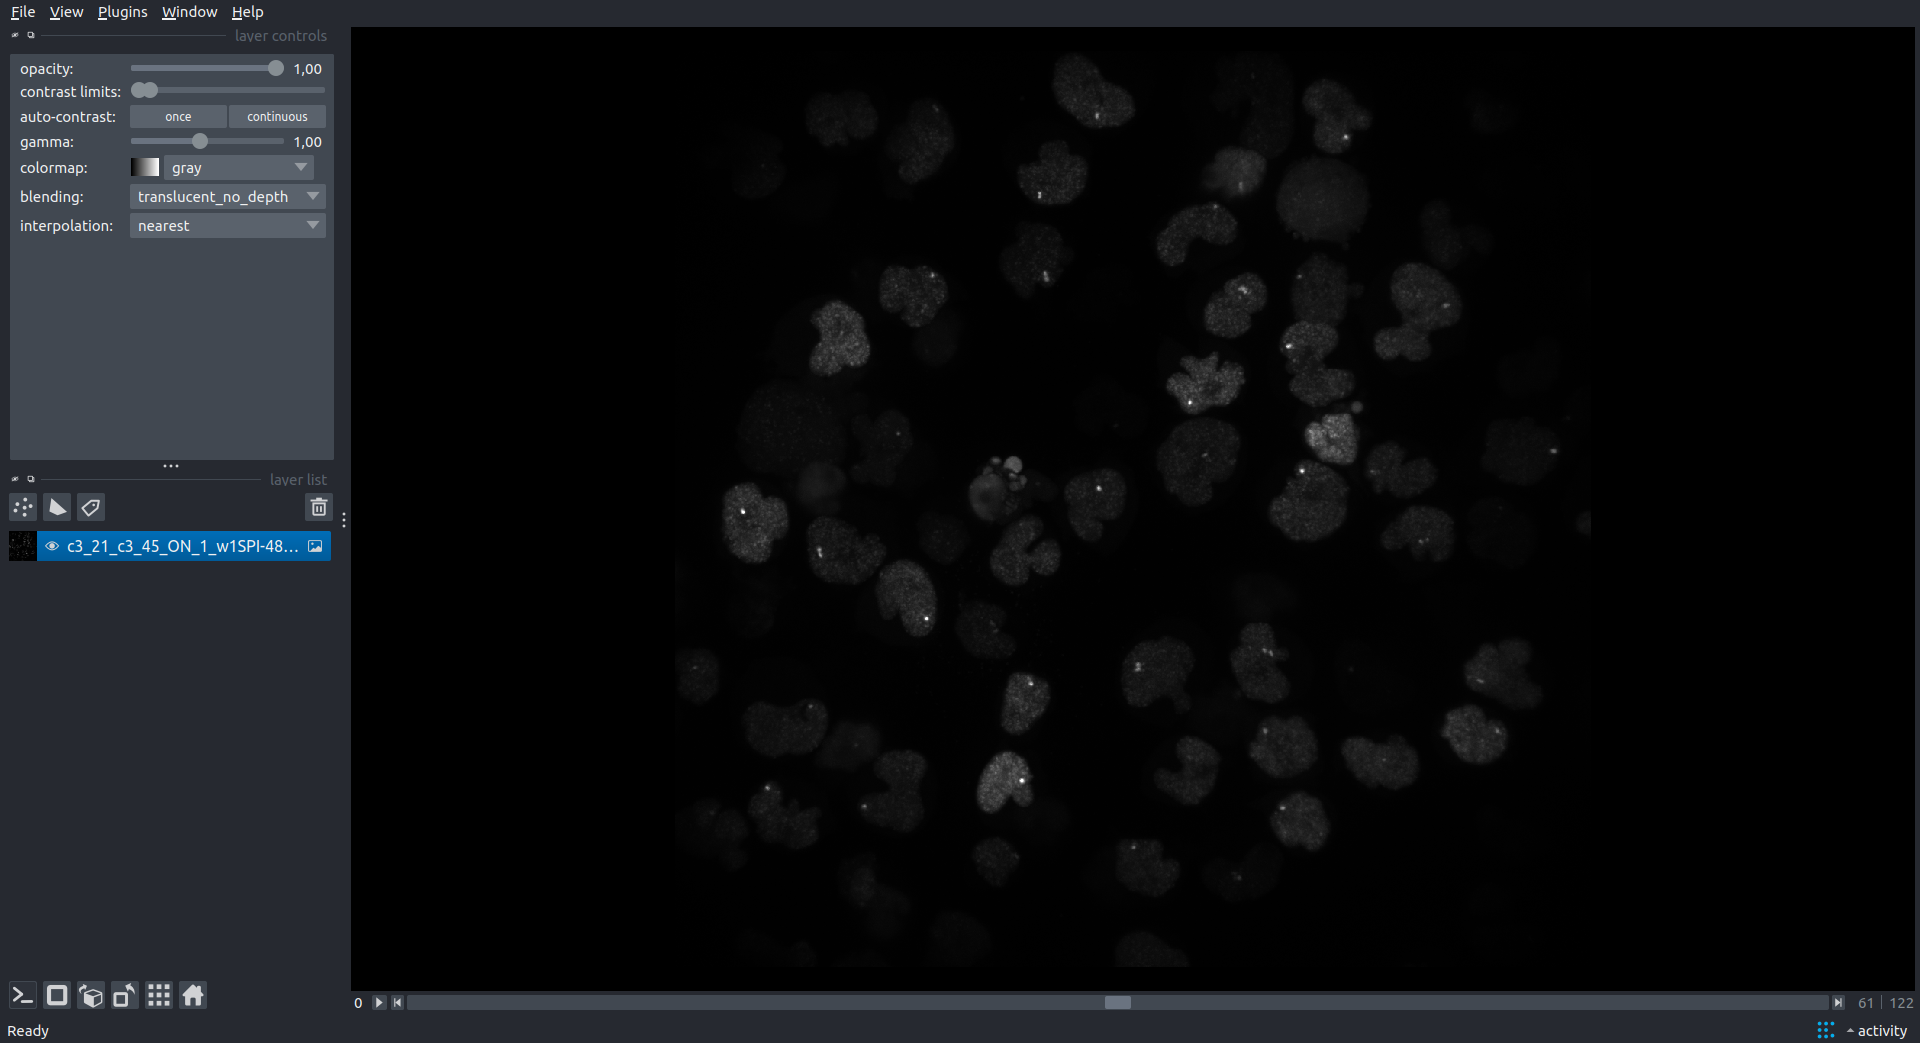

In [3]:
dataset_path = Path("/media/raphael/data/works/full_data_movie/c3_21_c3_45_ON_1_w1SPI-488_s3/MIP")

viewer = napari.Viewer()
viewer.window.resize(1800, 1000)
viewer.open(sorted(dataset_path.glob("*.tif")), stack=True)

image = viewer.layers[0].data

nbscreenshot(viewer)

In [4]:
cellpose_labels = imr('cellpose_s3/*.tif')
detection = imr('detection_img_s3/*.tif')
edges = imr('edges_s3/*.tif')

#cellpose_labels = cellpose_labels.compute()
#detection = detection.compute()
edges = edges.compute()


#edges = np.round(edges).astype(np.uint8)
viewer.add_labels(cellpose_labels, name='cellpose')
viewer.add_labels(detection, name='detection')
viewer.add_image(edges,blending="additive", colormap="magma")

<Image layer 'edges' at 0x7f2c887e4d90>

# 3. Tracking 

In [5]:
config = MainConfig()
pprint(config)

MainConfig(
│   data_config=DataConfig(working_dir=PosixPath('.'), database='sqlite', address=None, n_workers=1),
│   segmentation_config=SegmentationConfig(
│   │   threshold=0.5,
│   │   min_area=100,
│   │   max_area=1000000,
│   │   min_frontier=0.0,
│   │   anisotropy_penalization=0.0,
│   │   max_noise=0.0,
│   │   ws_hierarchy=<function watershed_hierarchy_by_area at 0x7f2cc2121bd0>,
│   │   n_workers=1
│   ),
│   linking_config=LinkingConfig(
│   │   n_workers=1,
│   │   max_neighbors=5,
│   │   max_distance=15.0,
│   │   distance_weight=0.0,
│   │   z_score_threshold=5.0
│   ),
│   tracking_config=TrackingConfig(
│   │   appear_weight=-0.001,
│   │   disappear_weight=-0.001,
│   │   division_weight=-0.001,
│   │   dismiss_weight_guess=None,
│   │   include_weight_guess=None,
│   │   window_size=None,
│   │   overlap_size=1,
│   │   solution_gap=0.001,
│   │   time_limit=36000,
│   │   method=0,
│   │   n_threads=-1,
│   │   link_function='power',
│   │   power=4,
│   │   bias=-0.0
│   )
)

Estimating params.: 100%|█████████████████████| 123/123 [00:03<00:00, 36.70it/s]


<Axes: title={'center': 'Area histogram'}, ylabel='Frequency'>

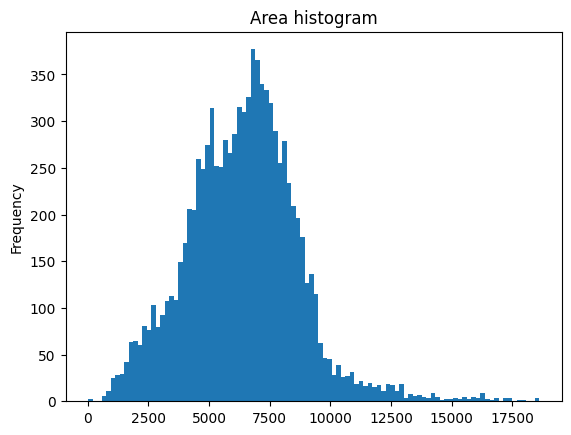

In [6]:
params_df = estimate_parameters_from_labels(cellpose_labels, is_timelapse=True)
params_df["area"].plot(kind="hist", bins=100, title="Area histogram")

In [7]:
weight = 25
workers = 8*2

In [8]:
config.segmentation_config.min_area = 500
config.segmentation_config.max_area = 12500
config.segmentation_config.n_workers = workers

In [12]:
config.linking_config.max_distance = 55 #maximum spatial distance between cells
config.linking_config.n_workers = workers #Number of worker threads
#config.linking_config.distance_weight = 0.01


config.tracking_config.appear_weight = -weight #appear_weight: Penalization weight for appearing cell, should be negative
config.tracking_config.disappear_weight = -weight #disappear_weight: Penalization for disappearing cell, should be negative 
config.tracking_config.division_weight = -weight/10 #division_weight: Penalization for dividing cell, should be negative
config.tracking_config.power = weight*4
config.tracking_config.bias = -0.01
config.tracking_config.solution_gap = 90 #solver solution gap
config.tracking_config.link_function = 'identity'


pprint(config)

MainConfig(
│   data_config=DataConfig(working_dir=PosixPath('.'), database='sqlite', address=None, n_workers=1),
│   segmentation_config=SegmentationConfig(
│   │   threshold=0.5,
│   │   min_area=500,
│   │   max_area=12500,
│   │   min_frontier=0.0,
│   │   anisotropy_penalization=0.0,
│   │   max_noise=0.0,
│   │   ws_hierarchy=<function watershed_hierarchy_by_area at 0x7f2cc2121bd0>,
│   │   n_workers=16
│   ),
│   linking_config=LinkingConfig(
│   │   n_workers=16,
│   │   max_neighbors=5,
│   │   max_distance=55,
│   │   distance_weight=0.0,
│   │   z_score_threshold=5.0
│   ),
│   tracking_config=TrackingConfig(
│   │   appear_weight=-25,
│   │   disappear_weight=-25,
│   │   division_weight=-2.5,
│   │   dismiss_weight_guess=None,
│   │   include_weight_guess=None,
│   │   window_size=None,
│   │   overlap_size=1,
│   │   solution_gap=90,
│   │   time_limit=36000,
│   │   method=0,
│   │   n_threads=-1,
│   │   link_function='identity',
│   │   power=100,
│   │   bias=-0.01
│   )
)

In [13]:
track(
    detection=detection,
    edges=edges,
    config=config,
    overwrite=True,
)

Linking nodes.: 100%|█████████████████████████| 122/122 [00:19<00:00,  6.30it/s]


Using Coin-OR Branch and Cut solver
Solving ILP batch 0
Constructing ILP ...
Solving ILP ...
Cgl0003I 387 fixed, 0 tightened bounds, 1613 strengthened rows, 368 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 25 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1123 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 719 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 584 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 305 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 212 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 55 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 25 strengthened rows, 0 substitutions
Cgl0004I processed model has 35207 rows, 58788 columns (58788 integer (58788 of which binary)) and 118278 elements
Coin3009W Conflict g

In [14]:

tracks_df, graph = to_tracks_layer(config)
labels = tracks_to_zarr(config, tracks_df)

Exporting segmentation masks: 100%|███████████| 123/123 [00:01<00:00, 64.84it/s]


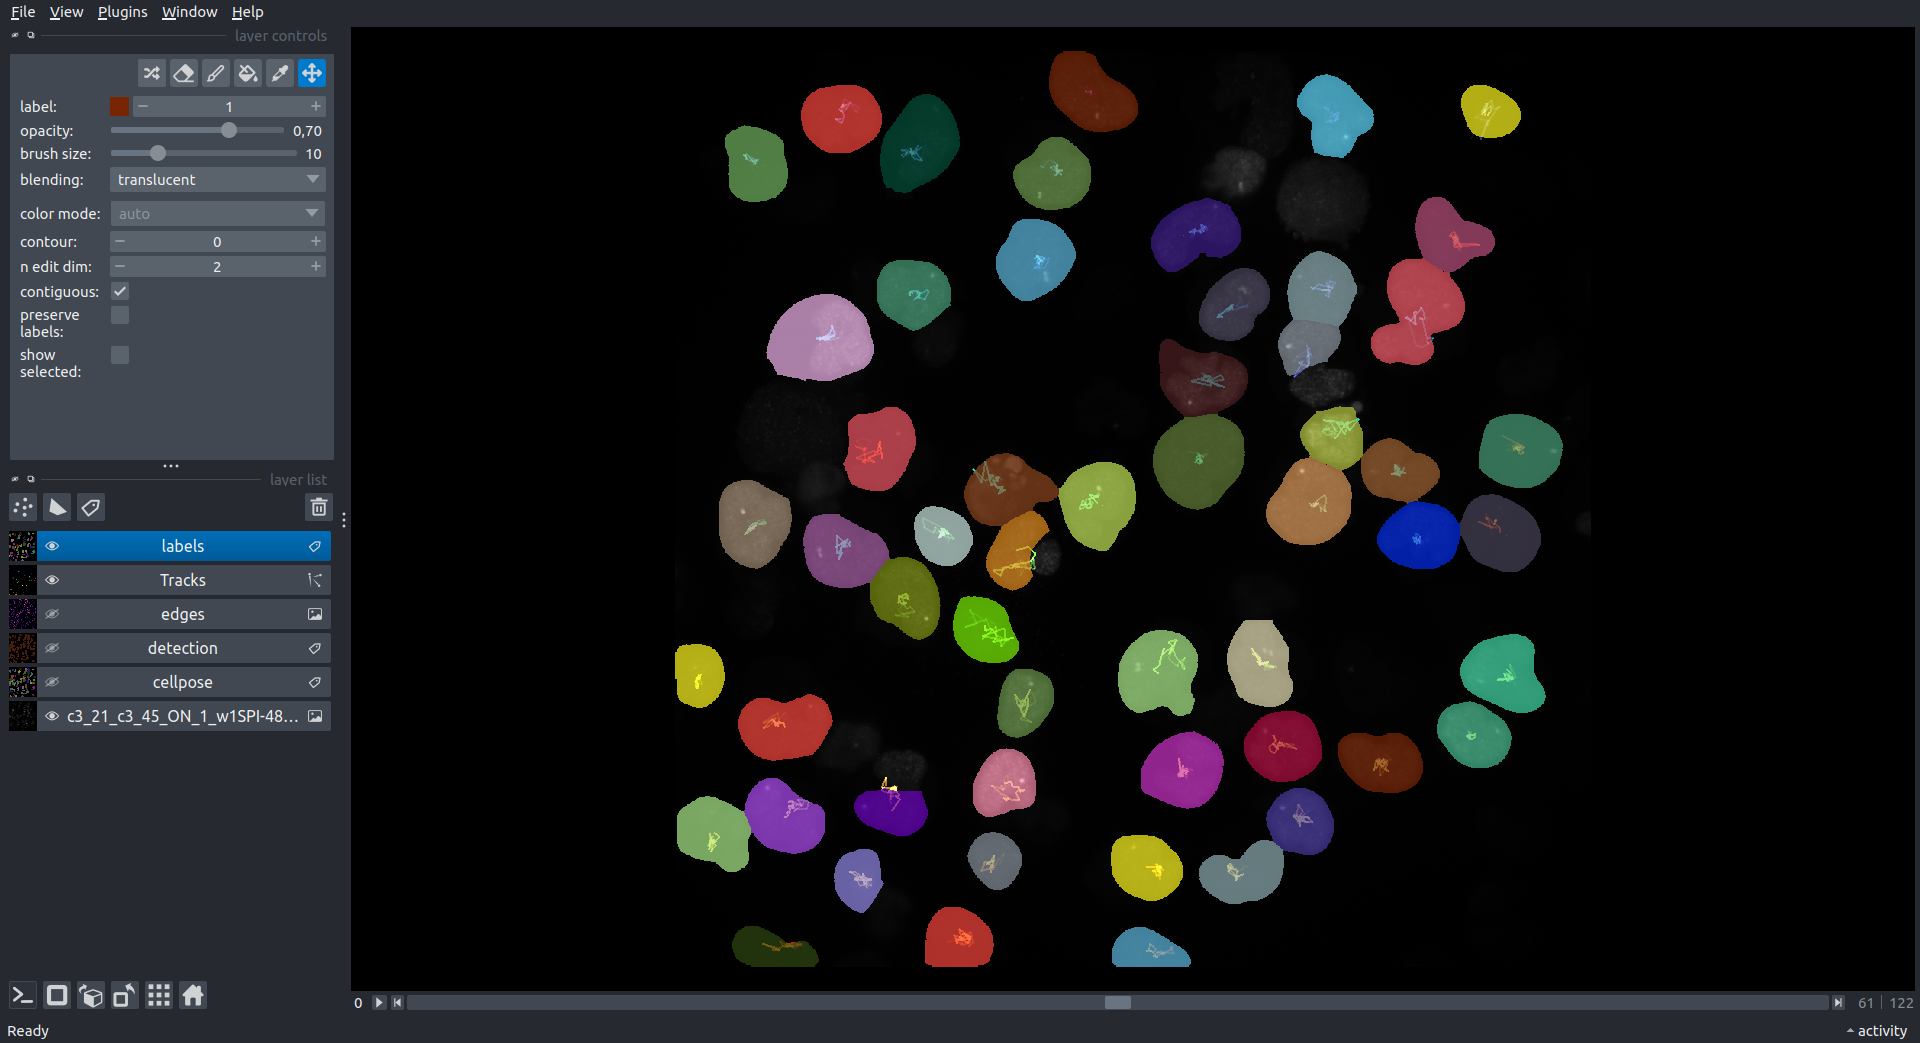

In [15]:
viewer.add_tracks(tracks_df[["track_id", "t", "y", "x"]].values, graph=graph)
viewer.add_labels(labels)

viewer.layers["cellpose"].visible = False
viewer.layers["edges"].visible = False
viewer.layers["detection"].visible = False
nbscreenshot(viewer)

In [16]:
percentage,cells_res = get_cells_numbers_on_all_frames(labels)

previous number of cells :  78
actual max number of cells :  78
number of cells present from first to last frame :  40
percentage of cells present from first to last frame :  51.28205128205128 %


In [17]:
cells_res

[0,
 1,
 7,
 8,
 9,
 10,
 11,
 13,
 14,
 16,
 17,
 18,
 23,
 24,
 25,
 29,
 30,
 32,
 33,
 34,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 54,
 55,
 56,
 57,
 58,
 64,
 65]

# 4. Save labels 

In [18]:
savepath = "/media/raphael/data/works/full_data_movie/c3_21_c3_45_ON_1_w1SPI-488_s3/MIP"
save_zarr_images(labels,savepath,"c3_21_c3_45_ON_1_w1SPI-488_s","3","labels")

Saving frame |████████████████████████████████████████| 123/123 [100%] in 14.9s 
